In [1]:
# Workaround for training output not visible in JupyterNotebook https://github.com/microsoft/vscode-jupyter/issues/13163
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [2]:
! pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz


/bin/bash: /home/mendhak/miniconda3/envs/fastai/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
import fastbook
fastbook.setup_book()

In [4]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

## Tabular Modeling

Take data in the form of a table, like CSV/spreadsheet. Predict the value in one column based on values in other columns. 
Some data are numerical like age, kilometers. Some data are strings like name, city. The numerical data can be fed directly to models, with optional preprocessing. The other columns need converting into numbers. These kinds of values are called categorical variables. Age, distance, are continuous variables. Categorical varibles can be numerical, or stored as numbers, but don't necessarily have meaning when multiplied. 

Modern machine learning has two key techniques: ensembles of decision trees (eg random forests, gradient boosting) for strucutred data. And multilayered neural networks (shallow/deep learning) for unstructured data. Decision tree ensembles are easy and fast to train and interpret, less tuning required, and are good at tabular data. The exceptions are high cardinality categorical variables (eg name, with lots of discrete values) and data like plain text... where deep learning may be preferred. The preferred libraries for decision trees are scikit and pandas. 

Blue Book for bulldozers dataset. The goal is to predict the sale price of a particular piece of heavy equipment at an auction based on usage, equipment type, configuration. 


In [5]:
!pip install kaggle

/bin/bash: /home/mendhak/miniconda3/envs/fastai/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
creds = ''
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [7]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/home/mendhak/.fastai/archive/bluebook-for-bulldozers')

In [8]:
Path.BASE_PATH = path

In [9]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)

api.competition_download_cli(comp, path=path)
shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

bluebook-for-bulldozers.zip: Skipping, found more recently modified local copy (use --force to force download)


(#7) [Path('median_benchmark.csv'),Path('random_forest_benchmark_test.csv'),Path('Test.csv'),Path('TrainAndValid.csv'),Path('Valid.csv'),Path('Machine_Appendix.csv'),Path('ValidSolution.csv')]

### Look at the data
Sales ID, Machine ID, saleprice, saledate. 

In [10]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [11]:
# An ordinal column - contains values with a natural ordering like size
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [12]:
# Tell pandas a suitable ordering, large to tiny
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [13]:
# most important data column is the one we want to predict, known as the dependent variable. 
# the metric is used to show how accurate the predictions are 
# in this case the metric to use is root mean squared log error beween actual and predicted auction prices. 
# to do that the sale price needs to be a log of the price so that rmse will give the right value
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

### Decision Trees
A decision tree asks a series of questions about the data. A prediction can be made or more questions asked to finally arrive at an answer. 
Through the series of questions, various data can get grouped together with other data that were 'questioned' in the same way. 
An implementation is built into scikit learn. 
For ordinal values (they follow a direction) the bisection would normally be based on a value threshold; for categorical variables it can be divided based on the particular level. 
Dates are different as they look ordinal but some dates can be different from others based on the model, eg day of week, holiday, month. A good approach then is to replace the date column with date metadata columns - holiday, day, month, year, etc. 

In [14]:
df = add_datepart(df, 'saledate') # splits into more date component parts

/home/mendhak/miniconda3/envs/fastai/lib/python3.9/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [15]:
# do the same for the test set
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/home/mendhak/miniconda3/envs/fastai/lib/python3.9/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [17]:
for c in df.columns:
    if c.startswith('sale'):
        print(c)

saleYear
saleMonth
saleWeek
saleDay
saleDayofweek
saleDayofyear
saleIs_month_end
saleIs_month_start
saleIs_quarter_end
saleIs_quarter_start
saleIs_year_end
saleIs_year_start
saleElapsed


More cleaning is required. sklearn doesn't deal with strings or missing data. 

In [18]:
procs = [Categorify, FillMissing]
# categorify replaes category column with a numeric categoric column. 
# fillmissing replaces missing values with median and creates a bool column to indicate true if a row was filled


In [19]:
# set up validation and test sets. 
cond = (df.saleYear < 2011) | (df.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx), list(valid_idx))

In [21]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var) 
# tabularpandass needs to know which columns are continuous and which are categorical,
# so this method helps

In [23]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [24]:
len(to.train), len(to.valid)

(404710, 7988)

In [25]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [26]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [28]:
to.items.head(3)  


,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [30]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [31]:
to.classes['ProductSize']

['#na#', 'Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

In [32]:
save_pickle(path/'to.pkl',to)

In [33]:
to = load_pickle(path/'to.pkl')

### Creating the decision tree


In [34]:
# define the dependent and independent variables. 
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [35]:
# create a decision tree
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

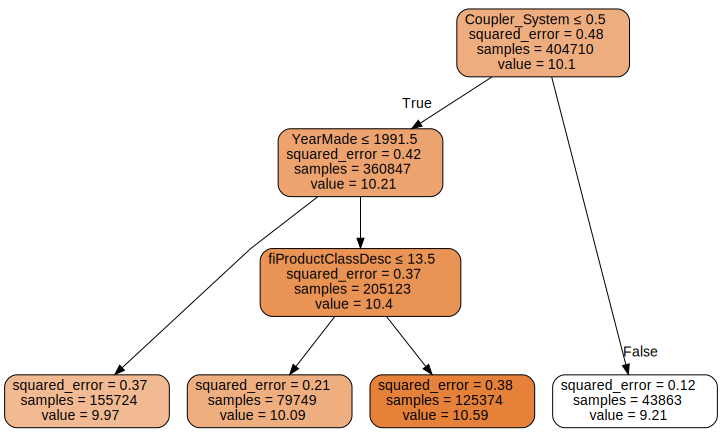

In [36]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [39]:
!pip install dtreeviz

/bin/bash: /home/mendhak/miniconda3/envs/fastai/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [43]:
from dtreeviz import *

In [44]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

/tmp/ipykernel_61557/1062975964.py:2: DeprecationWarning: dtreeviz() function is deprecated starting from version 2.0. 
 For the same functionality, please use this code instead: 
 m = dtreeviz.model(...) 
 m.view()


TypeError: 'int' object is not subscriptable

In [46]:
#now build a bigger tree 
m = DecisionTreeRegressor() # no max leafs
m.fit(xs, y)

DecisionTreeRegressor()

In [47]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [48]:
m_rmse(m, xs, y)

0.0

In [49]:
# Check validation set to ensure it's not overfitting
m_rmse(m, valid_xs, valid_y)

0.332819

In [50]:
m.get_n_leaves(), len(xs)
# shows nearly as many leaf nodes as data points, which is too many leaf nodes. 
# tell sklearn to make sure at least 25 points per leaf node. 

(324388, 404710)

In [51]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.210315, 0.262282)

In [52]:
m.get_n_leaves()
# better

12432